# A notebook to identify two different anatomical structures to show in Fig. 1g

Goal: Identify two AS in the same organ that have a low cosine similarity in terms of cell type population

## `import` statements

In [316]:
%pip install pyld pandas requests seaborn matplotlib hra_api_client

import hra_api_client

from hra_api_client.api import v1_api as default_api
from hra_api_client.models.aggregate_count import AggregateCount
from hra_api_client.models.database_status import DatabaseStatus
from hra_api_client.models.error_message import ErrorMessage
from hra_api_client.models.flat_spatial_placement import FlatSpatialPlacement
from hra_api_client.models.get_spatial_placement_request import GetSpatialPlacementRequest
from hra_api_client.models.min_max import MinMax
from hra_api_client.models.ontology_tree import OntologyTree
from hra_api_client.models.sparql_query_request import SparqlQueryRequest
from hra_api_client.models.spatial_entity import SpatialEntity
from hra_api_client.models.spatial_scene_node import SpatialSceneNode
from hra_api_client.models.spatial_search import SpatialSearch
from hra_api_client.models.tissue_block import TissueBlock

from pprint import pprint
from pyld import jsonld
import pandas as pd
import requests
from io import StringIO
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rcParams
import json

Note: you may need to restart the kernel to use updated packages.


In [317]:
# may need to remove `v1`
configuration = hra_api_client.Configuration(
    host="https://apps.humanatlas.io/api"
)

api_client = hra_api_client.ApiClient(configuration)

api_instance = default_api.V1Api(api_client)

## Set global variables

In [318]:
# hra-pop version to use
hra_pop_version = "v0.10.2"

# Load CTs by dataset
ds_cell_summaries = pd.read_csv(
    f"../../hra-pop/output-data/{hra_pop_version}/reports/atlas-ad-hoc/datasets-ct-bm-data.csv")

## Load hra-pop data

### AS-AS similarities

In [319]:
# make sure https://github.com/x-atlas-consortia/hra-pop/tree/main/ is cloned to the same root folder as this repository
# let's read this report that lists AS-AS similarities for all AS in HRApop
df_similarity_report = pd.read_csv(
    f"../../hra-pop/output-data/{hra_pop_version}/reports/atlas/figure-as-as-sim.csv")

# let's sort by cosime similarity so we can find two instances with a low cosine similarity
df_similarity_report = df_similarity_report.sort_values(by="cosine_sim")

df_similarity_report_filtered = df_similarity_report[(
    df_similarity_report['organ'] == "heart") & (df_similarity_report['sex'] == "Female")]
print(df_similarity_report_filtered)

            organId  organ     sex            modality  \
96   UBERON:0000948  heart  Female  sc_transcriptomics   
94   UBERON:0000948  heart  Female  sc_transcriptomics   
67   UBERON:0000948  heart  Female  sc_transcriptomics   
74   UBERON:0000948  heart  Female  sc_transcriptomics   
104  UBERON:0000948  heart  Female  sc_transcriptomics   
66   UBERON:0000948  heart  Female  sc_transcriptomics   
101  UBERON:0000948  heart  Female  sc_transcriptomics   
72   UBERON:0000948  heart  Female  sc_transcriptomics   
68   UBERON:0000948  heart  Female  sc_transcriptomics   
70   UBERON:0000948  heart  Female  sc_transcriptomics   
106  UBERON:0000948  heart  Female  sc_transcriptomics   
179  UBERON:0000948  heart  Female  sc_transcriptomics   
65   UBERON:0000948  heart  Female  sc_transcriptomics   
100  UBERON:0000948  heart  Female  sc_transcriptomics   
69   UBERON:0000948  heart  Female  sc_transcriptomics   

                   as1_label  \
96      right cardiac atrium   
94     

### Load cell type populations for AS

In [320]:
# Get data via grlc
url = "https://grlc.io/api-git/hubmapconsortium/ccf-grlc/subdir/hra-pop//cell_types_in_anatomical_structurescts_per_as.csv"

# Make the HTTP GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Read the CSV data into a DataFrame
    data = StringIO(response.text)
    df_hra_api = pd.read_csv(data)
    print(df_hra_api.head())  # Print the first few rows of the DataFrame
else:
    print(f"Failed to retrieve data: {response.status_code}")

             organ                                             as as_label  \
0  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
1  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
2  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
3  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   
4  Large Intestine  http://purl.obolibrary.org/obo/UBERON_0001153   caecum   

      sex        tool            modality  \
0  Female  celltypist  sc_transcriptomics   
1  Female  celltypist  sc_transcriptomics   
2  Female  celltypist  sc_transcriptomics   
3  Female  celltypist  sc_transcriptomics   
4  Female  celltypist  sc_transcriptomics   

                                             cell_id           cell_label  \
0         https://purl.org/ccf/ASCTB-TEMP_smc-plpp2-         SMC (PLPP2+)   
1  https://purl.org/ccf/ASCTB-TEMP_cycling-plasma...  Cycling plasma cell   
2  https://purl.org/ccf/ASCTB

## Functions

In [321]:
def get_cell_type_population(as_label: str, tool:str, sex:str, hra_api_response: pd.DataFrame):
    """Gets the cell type population for the provided as_label (string) from the HRA API

    Args:
                    as_label (str): human-readable label for the desired anatomical structure
                    
    Returns:    
                    result (dict): with cell labels, percentages, and the anatomical structure
    """
    # set up the result as a dict
    result = {
        'Cell Type': [],
        'Anatomical Structure': [],
        'Cell Percentage': [],
        'Cell Count': []
    } 
    
    # filter
    filtered_df = hra_api_response[(hra_api_response['as_label'] == as_label) & (hra_api_response['tool'] == tool) & (hra_api_response['sex'] == sex)]
    
    # get cell type and percentage pairs
    values = filtered_df[['cell_label', 'cell_percentage', 'cell_count']]
    
    result['Cell Type'] = values['cell_label']
    result['Anatomical Structure'] = [as_label] * len(values['cell_label'])
    result['Cell Percentage'] = values['cell_percentage']
    result['Cell Count'] = values['cell_count']

    return pd.DataFrame(result)

## Prepare the data for visualization

In [322]:
# Filter the right data
as_label_1 = "left cardiac atrium"
as_label_2 = "interventricular septum"
tool = "azimuth"
sex = "Female"

# get cell types and percentages for both
as_1_cells = get_cell_type_population(as_label_1, tool, sex, df_hra_api)
as_2_cells = get_cell_type_population(as_label_2, tool, sex, df_hra_api)

## Remove cells from male donor registered into female heart (interventricular septum)

In [323]:
# get dataset ID with male donor that we want to remove
dataset_to_remove = "https://entity.api.hubmapconsortium.org/entities/d6e6c8e452ed628425e9e928306a6db0"

# initialize dict for data frame to capture CTs and percentages/numbers to remove
cells_to_remove = {
    'Cell Type': [],
    'Cell Percentage': []
}

# get cell summary for this dataset and put into data frame
df_remove = (ds_cell_summaries[(ds_cell_summaries['dataset'] == dataset_to_remove) & (
    ds_cell_summaries['tool'] == "azimuth")]).drop_duplicates(subset=['cell_type_label', 'cell_type_percentage'])

# get rui loation IRI
rui_iri = "http://purl.org/ccf/1.5/1995aefd-5289-4652-a7e0-cc66c495649f"
remove_from_as = "interventricular septum"

# get rui location
extraction_site = api_instance.extraction_site(rui_iri)

# pump that jtno collision api endpoint
collisions = api_instance.collisions(extraction_site)

# and get collision percentage
collision_percentage = 0
for c in collisions:
  if c['label'] == remove_from_as:
    collision_percentage = c['percentage_of_tissue_block']

# go: SHOWN - CELLS from dataset * mesh collision percentage
# add percentage to df_remove
df_remove['percentage_of_collision_with_interventricular_septum'] = collision_percentage
df_remove['cells_to_remove'] = collision_percentage * df_remove['cell_type_count']
df_remove = df_remove[['cell_type_label','cells_to_remove']]

# rename column for match
df_remove = df_remove.rename(columns={'cell_type_label': 'Cell Type'})

df_remove

,Cell Type,cells_to_remove
28958,Pericyte,86.246
28963,Arterial Endothelial,43.326
28973,B,230.782
28983,Macrophage,87.058
28993,Atrial Cardiomyocyte,24.998
32022,Fibroblast,678.890
32024,Capillary Endothelial,80.794
32203,Venous Endothelial,46.284
32213,Mast,15.486
32223,T,29.812


In [324]:
# df to modify
as_2_cells

,Cell Type,Anatomical Structure,Cell Percentage,Cell Count
1356,Ventricular Cardiomycoyte,interventricular septum,0.368072,12463.890
1357,Capillary Endothelial,interventricular septum,0.181801,6156.269
1358,Fibroblast,interventricular septum,0.151964,5145.910
1359,Pericyte,interventricular septum,0.133297,4513.781
1360,Monocyte/cDC,interventricular septum,0.040764,1380.390
1361,Smooth Muscle,interventricular septum,0.023530,796.805
1362,Macrophage,interventricular septum,0.019225,651.023
1363,NK,interventricular septum,0.019080,646.083
1364,Arterial Endothelial,interventricular septum,0.012412,420.296
1365,T,interventricular septum,0.010715,362.827


In [325]:
# subtract cells and re-compute percentage
as_2_cells

# Merging on the 'Cell Type' column
as_2_cells_adjusted = pd.merge(as_2_cells, df_remove, on='Cell Type', how='inner')

as_2_cells_adjusted['Cell Count'] = as_2_cells_adjusted['Cell Count']-as_2_cells_adjusted['cells_to_remove']

# uncomment to remove col for dropped cells
as_2_cells_adjusted

# re-compute percentage
total_cells = as_2_cells_adjusted['Cell Count'].sum()
as_2_cells_adjusted['Cell Percentage'] = as_2_cells_adjusted['Cell Count'] / total_cells
    
as_2_cells_adjusted

,Cell Type,Anatomical Structure,Cell Percentage,Cell Count,cells_to_remove
0,Ventricular Cardiomycoyte,interventricular septum,0.346681,10526.110,1937.780
1,Capillary Endothelial,interventricular septum,0.200098,6075.475,80.794
2,Fibroblast,interventricular septum,0.147123,4467.020,678.890
3,Pericyte,interventricular septum,0.145823,4427.535,86.246
4,Monocyte/cDC,interventricular septum,0.041615,1263.520,116.870
5,Smooth Muscle,interventricular septum,0.025298,768.095,28.710
6,Macrophage,interventricular septum,0.018574,563.965,87.058
7,NK,interventricular septum,0.020341,617.605,28.478
8,Arterial Endothelial,interventricular septum,0.012416,376.970,43.326
9,T,interventricular septum,0.010968,333.015,29.812


In [326]:
# re-assign adjusted df to df for conatenating and visualization to remove cells from wrongly registered dataset
as_2_cells = as_2_cells_adjusted

In [327]:
# set filter
as_1_cells = as_1_cells[(as_1_cells['Cell Percentage'] >= 0.05)]
as_2_cells = as_2_cells[(as_2_cells['Cell Percentage'] >= 0.05)]

# concatenate the two data frames
concatenated_df = pd.concat([as_1_cells, as_2_cells], ignore_index=True)
concatenated_df

,Cell Type,Anatomical Structure,Cell Percentage,Cell Count,cells_to_remove
0,Atrial Cardiomyocyte,left cardiac atrium,0.321545,5817.020,NaN
1,Pericyte,left cardiac atrium,0.187391,3390.065,NaN
2,Fibroblast,left cardiac atrium,0.147331,2665.335,NaN
3,Capillary Endothelial,left cardiac atrium,0.124877,2259.130,NaN
4,Ventricular Cardiomycoyte,interventricular septum,0.346681,10526.110,1937.780
5,Capillary Endothelial,interventricular septum,0.200098,6075.475,80.794
6,Fibroblast,interventricular septum,0.147123,4467.020,678.890
7,Pericyte,interventricular septum,0.145823,4427.535,86.246


## Visualize

C:\Users\abueckle\AppData\Local\Temp\1\ipykernel_45972\2332194588.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])


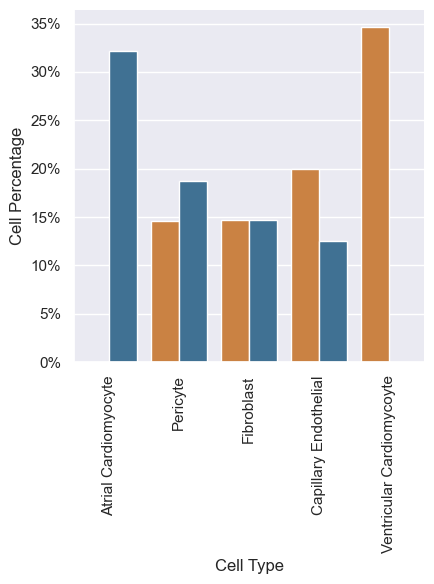

In [345]:
# Set order for bars
group_order = ['interventricular septum', 'left cardiac atrium']

# set colors
custom_palette = {'interventricular septum': '#E1812C',
                  'left cardiac atrium': '#3274A1'}

# create grouped bar graph using seaborn
plot = sns.catplot(
    data=concatenated_df,
    x='Cell Type',
    y='Cell Percentage',
    hue='Anatomical Structure',
    kind='bar',
    height=5,
    aspect=.75,
    # legend_out=False,
    legend=False,
    hue_order=group_order,
    palette=custom_palette
)

# set fig size
plt.gcf().set_size_inches(4.5, 6)

# convert y-axis to percent
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])

# rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# tighten the layout
plt.tight_layout()

# save the fig
plt.savefig("output/fig-1g.svg")
plt.savefig("output/fig-1g.pdf")
plt.savefig("output/fig-1g.png")

# render the plot
plt.show()

## Visualize cell types per dataset as bar graph

### Get dataset IDs for female heart AS from AS Cell Summaries

In [329]:
# AS to show datasets for
as_to_show = as_label_1

with open(f"../../hra-pop/output-data/{hra_pop_version}/atlas-as-cell-summaries.jsonld") as f:
    data = json.load(f)

cell_summaries = [summary for summary in data["@graph"]
                  if (summary['cell_source_label'] == as_to_show) and summary['sex'] == sex and summary['annotation_method'] == tool]


pprint(cell_summaries)

[{'@type': 'CellSummary',
  'aggregated_summaries': ['https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D4$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D5$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D11$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H6$left%20cardiac%20atrium',
                           'https://api.cellxgene.cziscience.com/dp/v1/collecti

### Get dataset IDs

In [330]:
datasets_to_keep = []
look_up = {}

for item in [id['aggregated_summaries'] for id in cell_summaries ]:
  datasets_to_keep.extend(item)

datasets_to_keep

['https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D4$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D5$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D11$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H6$left%20cardiac%20atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H7$left%20cardiac%20atrium']

### Make look-up from dataset to AS

In [331]:
look_up = {}

for id in datasets_to_keep:
	for summary in cell_summaries:
		if id in summary['aggregated_summaries']:
			look_up[id] = summary['cell_source_label']

look_up

{'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D1$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D4$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D5$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#D11$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H5$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H6$left%20cardiac%20atrium': 'left cardiac atrium',
 'https://api.cellxgene.cziscience.com/dp/v1/collections/b52eb423-5d0d-4645-b217-e1c6d38b2e72#H7$left%20cardiac%20atrium': 

### Get cell summaries for datasets

In [332]:
# filter to only keep datasets in AS
df = ds_cell_summaries[(ds_cell_summaries['dataset'].isin(
    datasets_to_keep)) & (ds_cell_summaries['sex'] == sex) & (ds_cell_summaries['tool'] == tool)]

# Select 3 columns
selected_columns = df[['dataset', 'sex', 'tool', 'cell_type_label', 'cell_type_percentage']]

# Drop duplicates
unique_df = selected_columns.drop_duplicates()

# Add column for AS
unique_df['anatomical_structure'] = unique_df['dataset'].map(look_up)

# print unique_df
unique_df

C:\Users\abueckle\AppData\Local\Temp\1\ipykernel_45972\2382502695.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_df['anatomical_structure'] = unique_df['dataset'].map(look_up)


,dataset,sex,tool,cell_type_label,cell_type_percentage,anatomical_structure
67743,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Pericyte,0.146204,left cardiac atrium
68598,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Macrophage,0.014058,left cardiac atrium
68602,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Arterial Endothelial,0.001874,left cardiac atrium
68811,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Adipocyte,0.005623,left cardiac atrium
68821,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Smooth Muscle,0.004686,left cardiac atrium
...,...,...,...,...,...,...
154083,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,B,0.008686,left cardiac atrium
154093,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Mast,0.001961,left cardiac atrium
156461,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Mesothelial,0.000560,left cardiac atrium
158693,https://api.cellxgene.cziscience.com/dp/v1/col...,Female,azimuth,Atrial Cardiomyocyte,0.230769,left cardiac atrium


### Visualize

C:\Users\abueckle\AppData\Local\Temp\1\ipykernel_45972\3490188003.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])


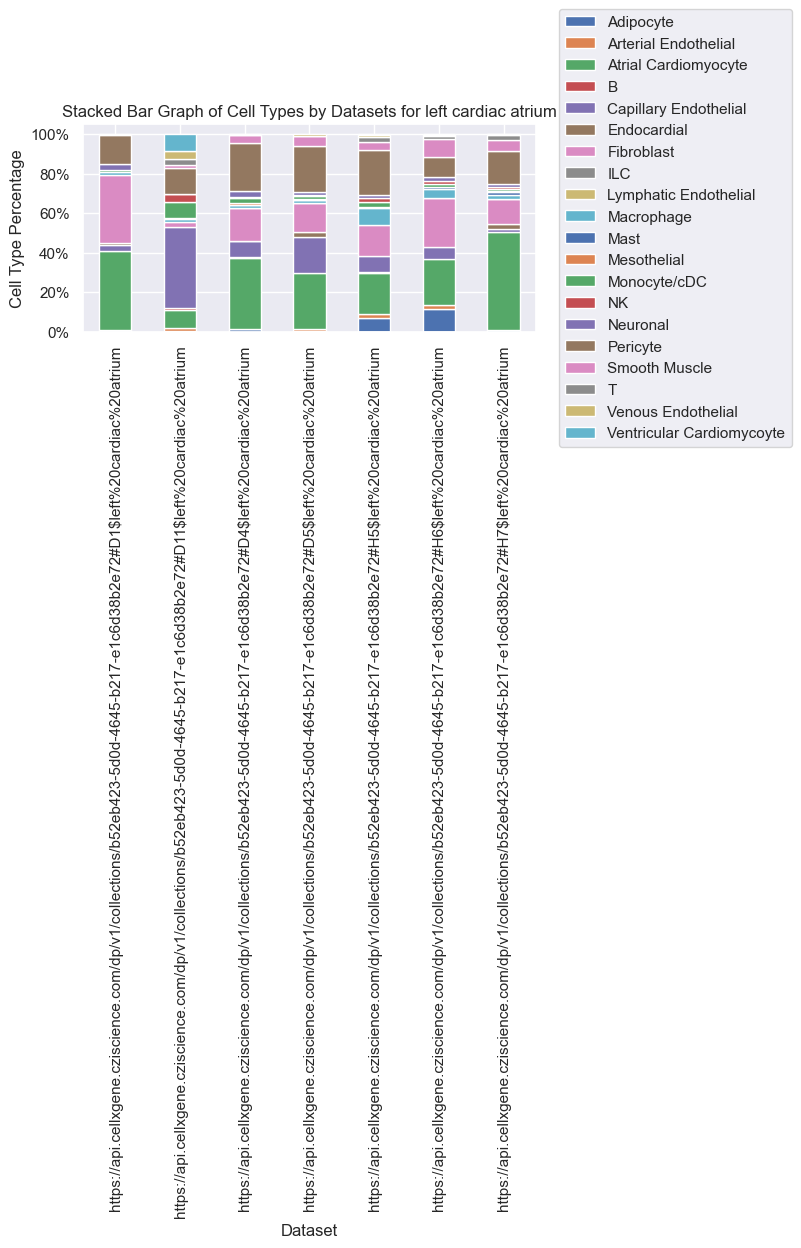

In [333]:
# Pivot the DataFrame to get Subcategories as columns
df_pivot = unique_df.pivot(index='dataset', columns='cell_type_label',
                           values='cell_type_percentage')

# Plotting
df_pivot.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Cell Type Percentage')
plt.title(f'Stacked Bar Graph of Cell Types by Datasets for {as_to_show}')

# set size
sns.set_theme(rc={'figure.figsize': (8.27, 11.7)})

# convert y-axis to percent
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:.0%}'.format(val) for val in vals])

# # rotate x-axis tick labels by 90 degrees
plt.xticks(rotation=90)

# Add a legend with bbox_to_anchor
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    borderaxespad=0.
)

# # tighten the layout
plt.tight_layout()

# render the plot
plt.show()